In [3]:
%matplotlib inline
from importlib import reload
from pathlib import Path

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', palette='muted')

from types import SimpleNamespace

from TreeMazeAnalyses2.Analyses import subject_info as si
import TreeMazeAnalyses2.Analyses.tree_maze_functions as tmf
import Analyses.spatial_functions as spatial_funcs
import Utils.filter_functions as filter_funcs

from pykalman import KalmanFilter
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)


# Notebook to demonstrate behavioral data pre-processing

In [4]:
# load a session
si = reload(si)
session = 'Li_T3g_070618'
subject = session.split('_')[0]
session_info = si.SubjectSessionInfo(subject, session)

In [84]:
parans = {
                # pixel params
                'x_pix_lims': [100, 650],  # camera field of view x limits [pixels]
                'y_pix_lims': [100, 500],  # camera field of view y limits [pixels]
                'x_pix_bias': -380,  # factor for centering the x pixel position
                'y_pix_bias': -280,  # factor for centering the y pixel position
                'vt_rate': 1.0 / 60.0,  # video acquisition frame rate
                'xy_pix_rot_rad': np.pi / 2 + 0.04,  # rotation of original xy pix camera to experimenter xy

                # conversion params
                'x_pix_mm': 1165.0 / 255.0,  # pixels to mm for the x axis [pix/mm]
                'y_pix_mm': 1320.0 / 329.0,  # pixels to mm for the y axis [pix/mm]
                'x_mm_bias': 20,  # factor for centering the x mm position
                'y_mm_bias': 660,  # factor for centering the y mm position
                'x_mm_lims': [-630, 630],  # limits on the x axis of the maze [mm]
                'y_mm_lims': [-60, 1350],  # limits on the y axis of the maze [mm]
                'x_cm_lims': [-63, 63],  # limits on the x axis of the maze [cm]
                'y_cm_lims': [-6, 135],  # limits on the y axis of the maze [cm]
                'max_speed_thr': 100, 
                'min_speed_thr': 2, 
                'temporal_window_size': 5,  # smoothing temporal window for filtering [bins]
                'temporal_angle_window_size': 5,  # smoothing temporal window for angles [bins]
                'temporal_window_type': 'hann',  # window type for temporal window smoothing

                # statistical tests parameters:
            }

parans['filter_coef_'] = si.signal.get_window(parans['temporal_window_type'],
                                              parans['temporal_window_size'],
                                              fftbins=False)
parans['filter_coef_'] /= parans['filter_coef_'].sum()

parans['filter_coef_angle_'] = si.signal.get_window(parans['temporal_window_type'],
                                                    parans['temporal_angle_window_size'],
                                                    fftbins=False)
parans['filter_coef_angle_'] /= parans['filter_coef_angle_'].sum()
    
p = SimpleNamespace(**parans)

In [24]:
tmf = reload(tmf)
tree_maze = tmf.TreeMazeZones(sub_seg_length=50)

In [6]:
t_rs = session_info.get_time()
# get raw behavior
t_vt, x_vt, y_vt, ha_vt = session_info.get_raw_track_data()

(-30.700000000000003, 644.7, -23.75, 651.6500000000001)

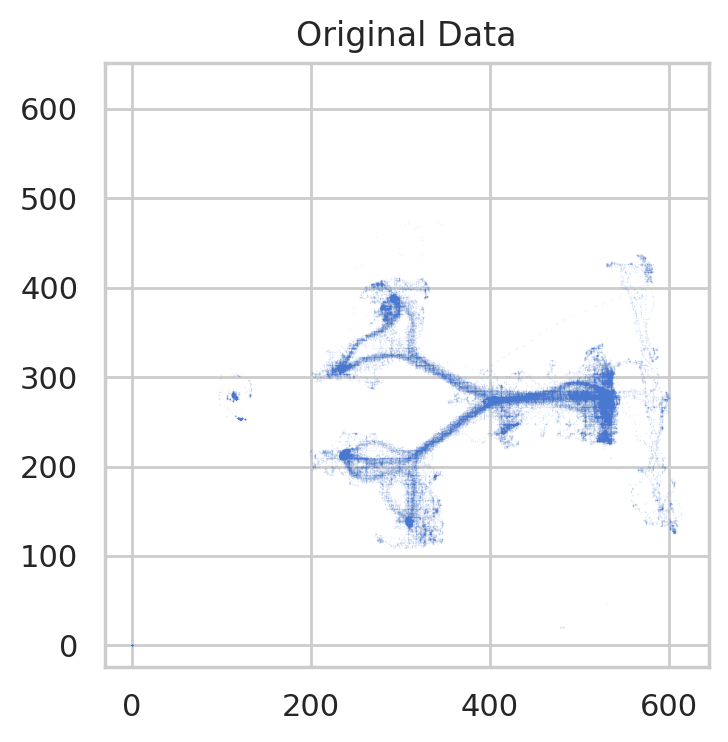

In [14]:
f,ax=plt.subplots(dpi=200)
ax.scatter(x_vt,y_vt, s=1, marker = '.', alpha=0.1, linewidth=0)
ax.set_title("Original Data")
ax.axis("square")

(74.3, 639.7, 90.7, 656.1000000000001)

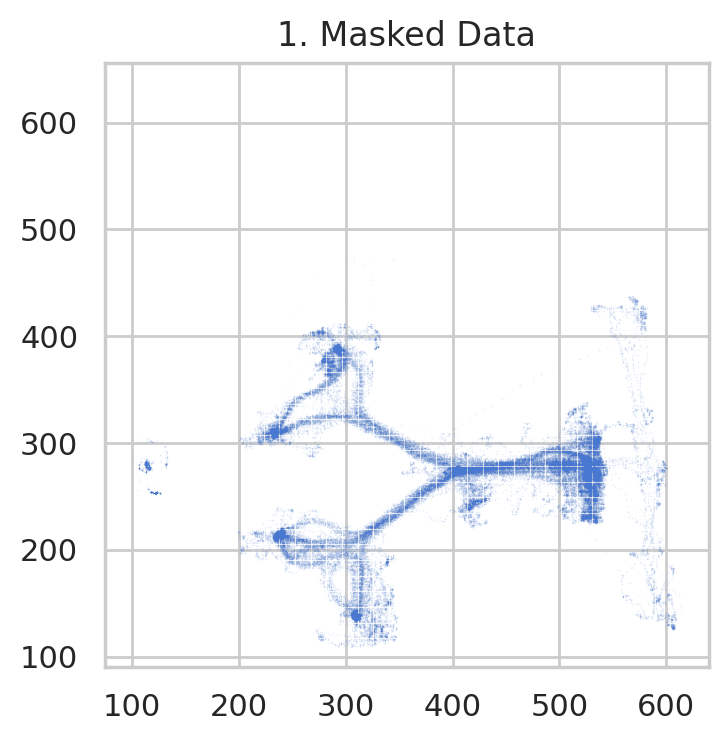

In [15]:
x = x_vt.copy()
y = y_vt.copy()
    
# 1. mask out of bound data
mask_x = np.logical_or(x < p.x_pix_lims[0], x > p.x_pix_lims[1])
mask_y = np.logical_or(y < p.y_pix_lims[0], y > p.y_pix_lims[1])
mask = np.logical_or(mask_x, mask_y)

x[mask] = np.nan
y[mask] = np.nan

f,ax=plt.subplots(dpi=200)
ax.scatter(x, y, s=1, marker = '.', alpha=0.1, linewidth=0)
ax.set_title("1. Masked Data")
ax.axis("square")

(-305.7, 259.7, -189.3, 376.09999999999997)

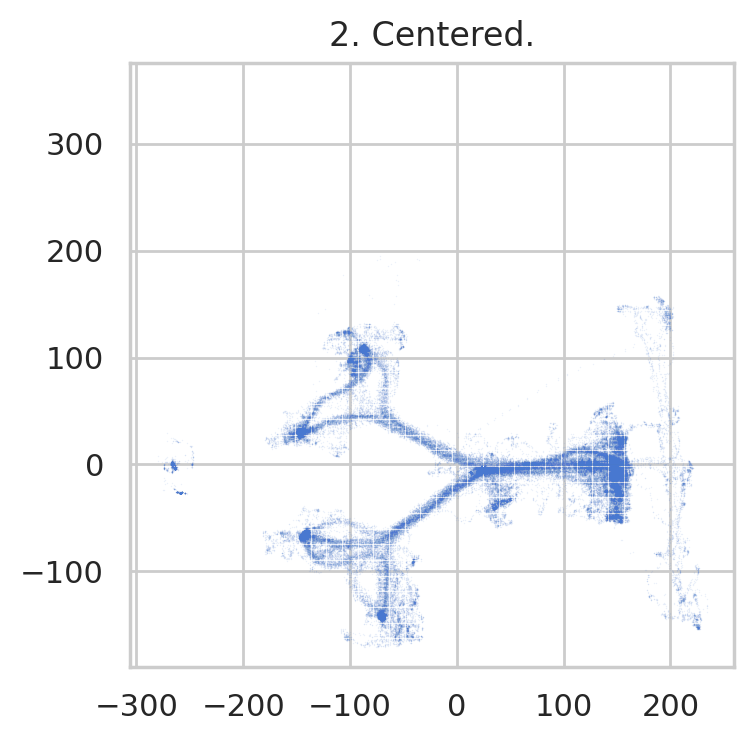

In [17]:
# 2. centering / pixel translation
x2 = x + p.x_pix_bias
y2 = y + p.y_pix_bias
f,ax=plt.subplots(dpi=200)
#ax.scatter(x2, y2, s=0.5, marker = '.', alpha=0.02)
ax.scatter(x2, y2, s=1, marker = '.', alpha=0.1, linewidth=0)
ax.set_title("2. Centered.")
ax.axis("square")

(-185.72731474394934,
 371.87403836385533,
 -252.75570165467138,
 304.8456514531333)

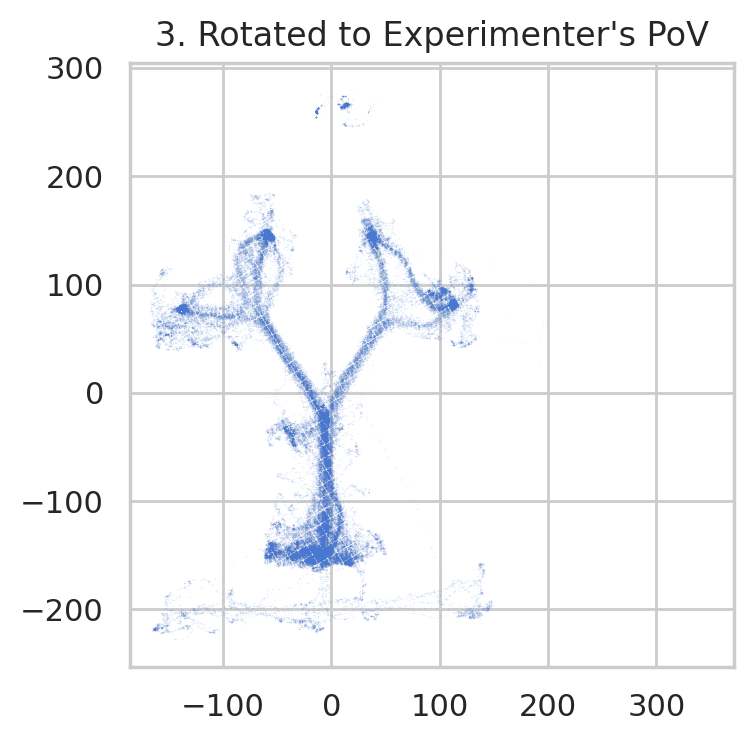

In [106]:
# 3. rotate to experimenter's pov
p.xy_pix_rot_rad =  np.pi / 2 + 0.05
x3, y3 = spatial_funcs.rotate_xy(x2, y2, p.xy_pix_rot_rad)
f,ax=plt.subplots(dpi=200)
ax.scatter(x3, y3, s=1, marker = '.', alpha=0.1, linewidth=0)
ax.set_title("3. Rotated to Experimenter's PoV")
ax.axis("square")

(-1182.586816840355,
 1248.5550827096736,
 -462.01485921436745,
 1969.1270403356611)

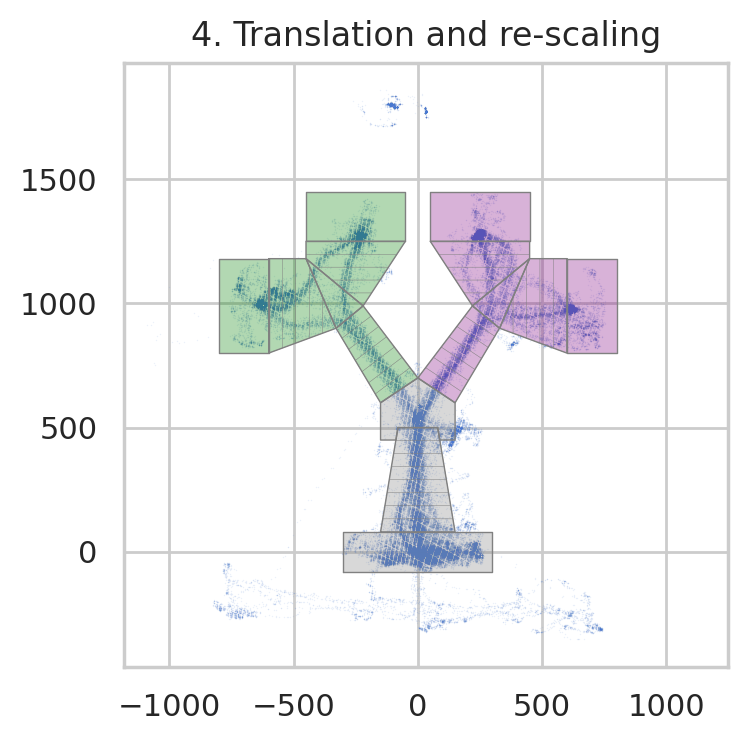

In [107]:
# 4. convert to mm / re-scales; bias term re-frames the image
# x4 = x3 * p.x_pix_mm + p.x_mm_bias
# y4 = y3 * p.y_pix_mm + p.y_mm_bias
p.x_pix_mm = 1358/269
p.x_mm_bias = 35

p.y_pix_mm = 1308 / 300
p.y_mm_bias = 640

x4 = -(x3 * p.x_pix_mm + p.x_mm_bias)
x4[x4 < 0] = x4[x4 < 0] * 1.05  # left warping
x4[x4 > 0] = x4[x4 > 0] * 0.93  # left warping


y4 = y3 * p.y_pix_mm + p.y_mm_bias

f,ax=plt.subplots(dpi=200)
ax = tree_maze.plot_maze(seg_color='cue', zone_labels=False, seg_dir='in', font_size=5, lw=0.5, sub_segs='all', sub_seg_lw=0.1, sub_seg_color='None', axis=ax, tm_layout=True)

#ax.scatter(x4, y4, s=0.5, marker = '.', alpha=0.02)
ax.scatter(x4, y4, s=1, marker = '.', alpha=0.1, linewidth=0)

ax.set_title("4. Translation and re-scaling")
ax.axis("square")

#ax = tree_maze.plot_maze(seg_color='cue', zone_labels=False, seg_dir='in', font_size=5, lw=0.5, sub_segs='all', sub_seg_lw=0.1, sub_seg_color='None', axis=ax)

ax.axis("on")


In [104]:
dx = np.append(0, np.diff(x4))
dy = np.append(0, np.diff(y4))
dr = np.sqrt(dx ** 2 + dy ** 2)

(-156.5, 1526.5)

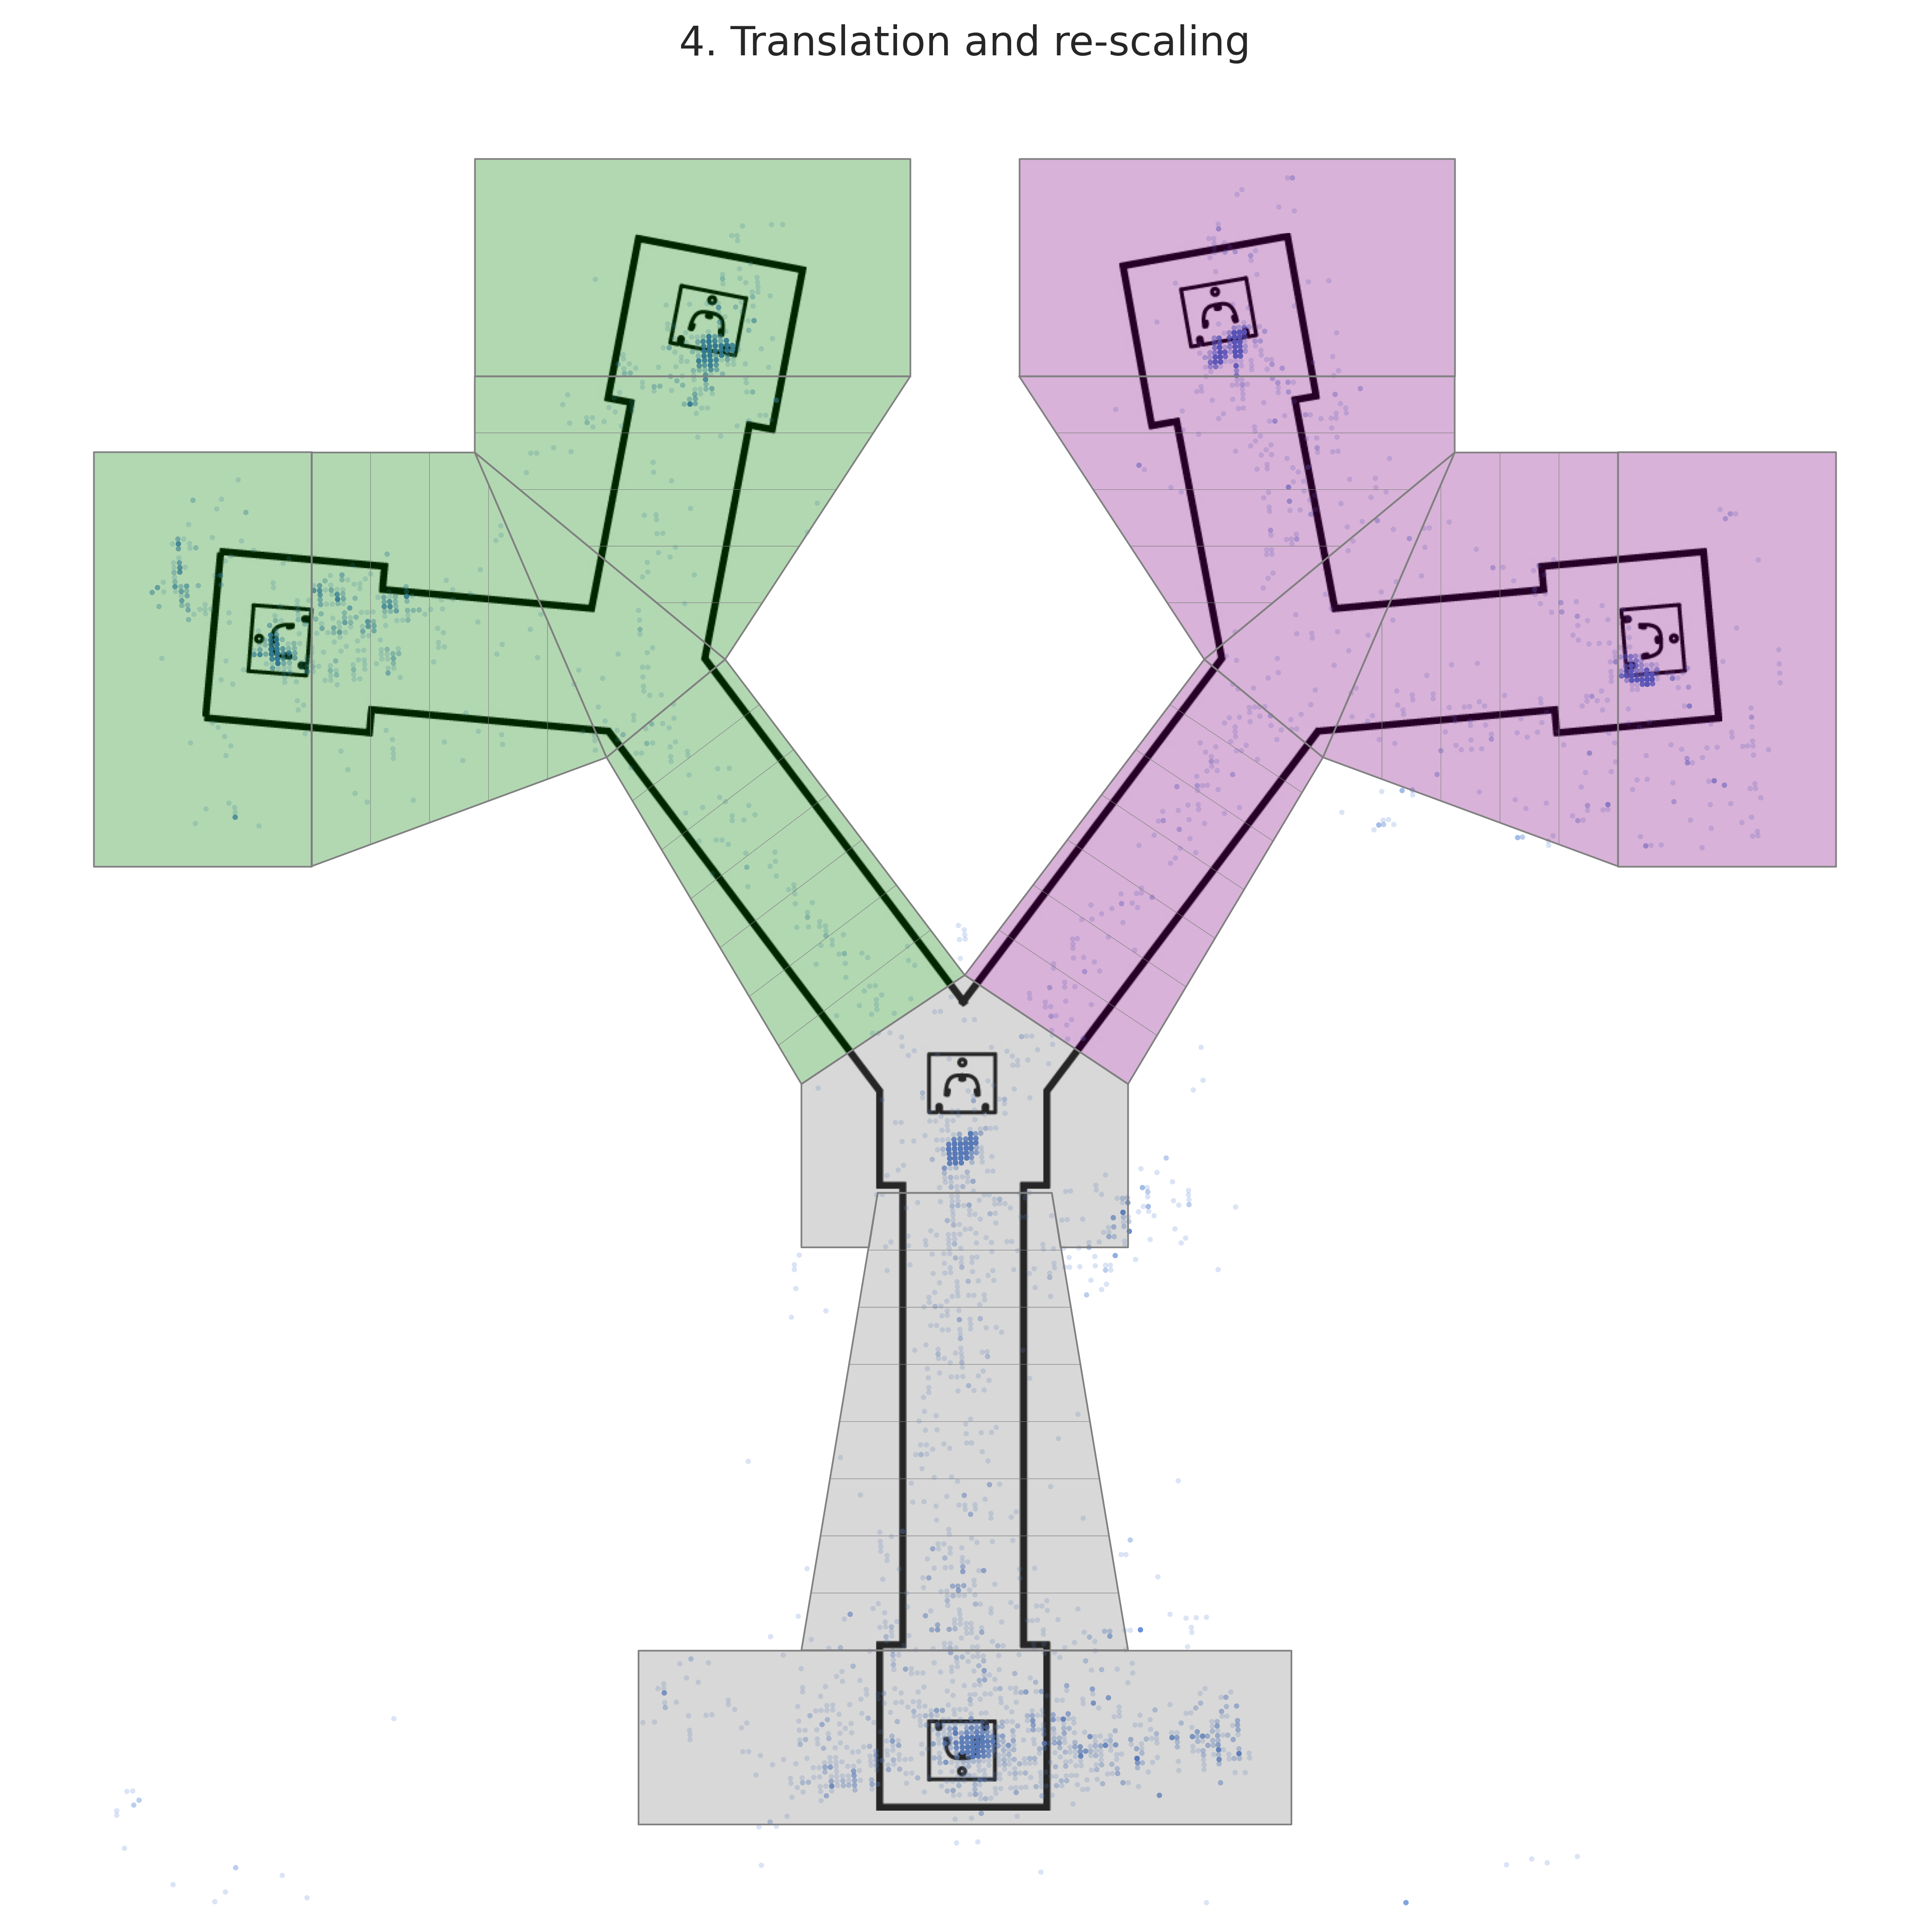

In [108]:
ax = tree_maze.plot_maze(seg_color='cue', zone_labels=False, seg_dir='in', font_size=5, lw=0.5, sub_segs='all', sub_seg_lw=0.1, sub_seg_color='None', tm_layout=True)


xlims = ax.get_xlim()
ylims = ax.get_ylim()

#f,ax=plt.subplots(dpi=200)
#ax.scatter(x4, y4, s=0.5, marker = '.', alpha=0.02)
ax.scatter(x4[dr<1], y4[dr<1], s=10, marker = '.', alpha=0.2, linewidth=0)

ax.set_title("4. Translation and re-scaling")
ax.set_xlim(xlims)
ax.set_ylim(ylims)
#ax.axis("square")


#ax.axis("on")

(-684.2205888148134, 874.5413036393251, -135.7662340674091, 1422.9956583867292)

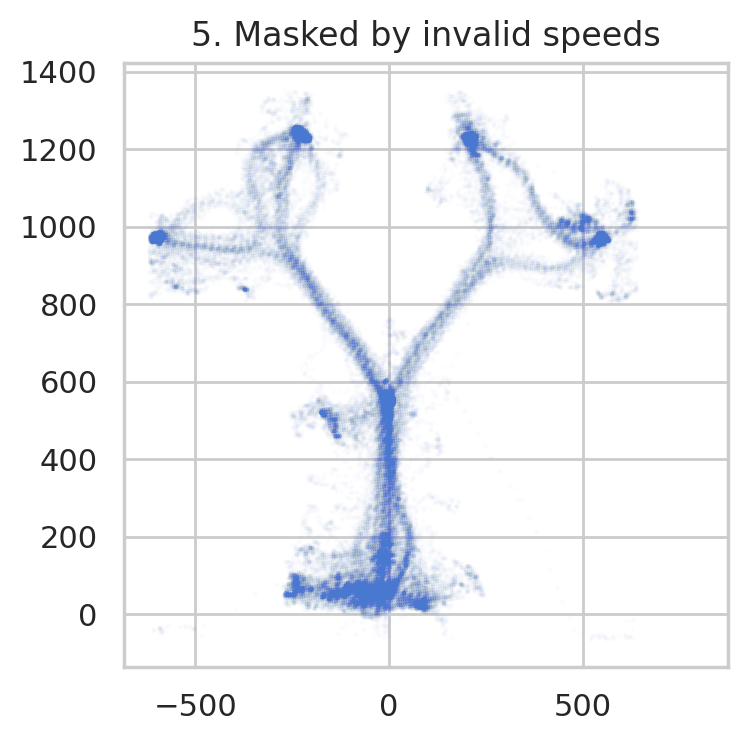

In [152]:
with np.errstate(invalid='ignore'):  # avoids warnings about comparing nan values
    # 5. compute velocity to create speed threshold
    dx = np.append(0, np.diff(x4))
    dy = np.append(0, np.diff(y4))
    dr = np.sqrt(dx ** 2 + dy ** 2)
    mask_r = np.abs(dr) > p.max_speed_thr

    # 6. mask creating out of bound zones in mm space
    mask_x = np.logical_or(x4 < p.x_mm_lims[0], x4 > p.x_mm_lims[1])
    mask_y = np.logical_or(y4 < p.y_mm_lims[0], y4 > p.y_mm_lims[1])
    mask = np.logical_or(mask_x, mask_y)
    mask = np.logical_or(mask, mask_r)

# 7. apply masks
x5[mask] = np.nan
y5[mask] = np.nan

f,ax=plt.subplots(dpi=200)
ax.scatter(x5, y5, s=0.5, marker = '.', alpha=0.02)
ax.set_title("5. Masked by invalid speeds")
ax.axis("square")

(-674.7484109034963,
 863.9104622061723,
 -127.97896517711918,
 1410.6799079325494)

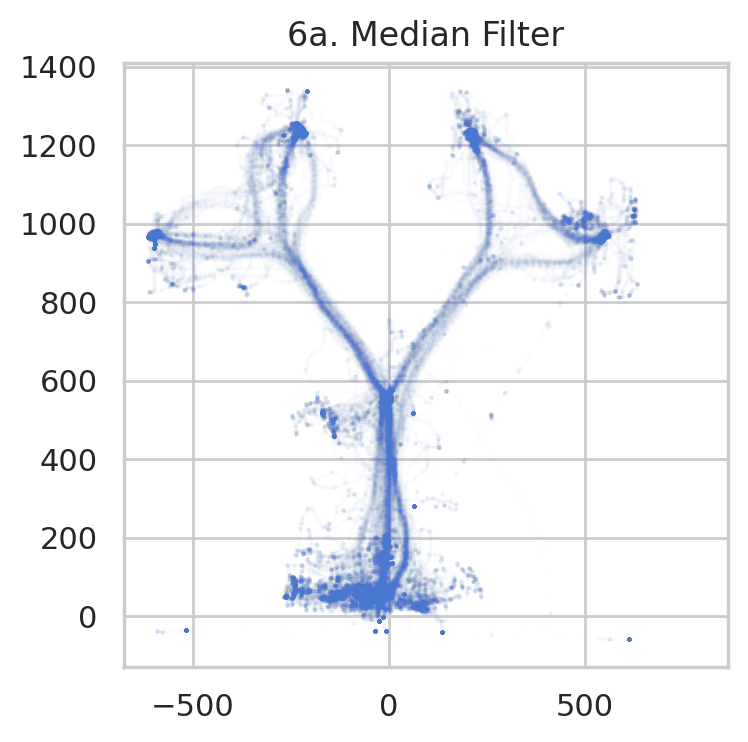

In [158]:
 # 8. median filter the data to deal with nan
x6a = filter_funcs.median_window_filtfilt(x5, 11)
y6a = filter_funcs.median_window_filtfilt(y5, 11)

f,ax=plt.subplots(dpi=200)
ax.scatter(x6a, y6a, s=0.5, marker = '.', alpha=0.02)
ax.set_title("6a. Median Filter")
ax.axis("square")


(-684.2205888148134, 874.5413036393251, -135.7662340674091, 1422.9956583867292)

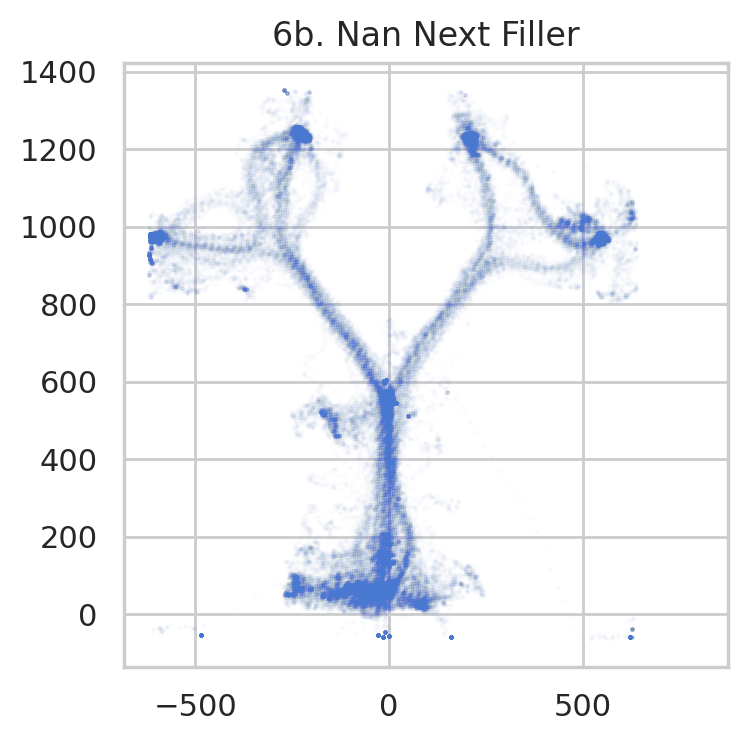

In [159]:
# 9. if there are still NaNs assign id to previous value
filter_funcs = reload(filter_funcs)

x6b = filter_funcs.fill_nan_vals(x5)
y6b = filter_funcs.fill_nan_vals(y5)

f,ax=plt.subplots(dpi=200)
ax.scatter(x6b, y6b, s=0.5, marker = '.', alpha=0.02)
ax.set_title("6b. Nan Next Filler")
ax.axis("square")

/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(-684.2205888148134, 874.5413036393251, -135.7662340674091, 1422.9956583867292)

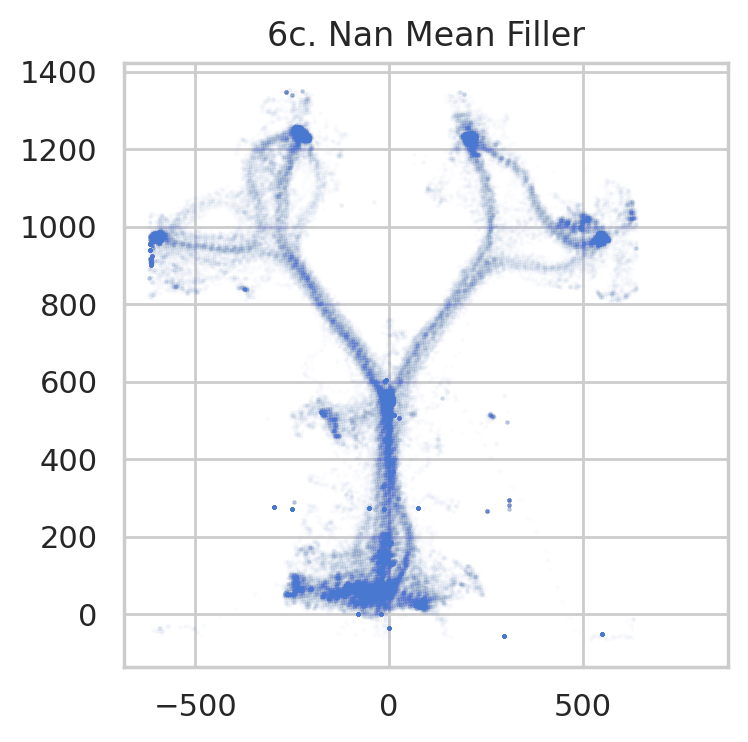

In [163]:
# 9. if there are still NaNs assign id to previous value
filter_funcs = reload(filter_funcs)

x6c = filter_funcs.fill_nan_vals(x5, method='Both')
y6c = filter_funcs.fill_nan_vals(y5, method='Both')

f,ax=plt.subplots(dpi=200)
ax.scatter(x6c, y6c, s=0.5, marker = '.', alpha=0.02)
ax.set_title("6c. Nan Mean Filler")
ax.axis("square")

(-683.3091827725174,
 872.0800480403792,
 -132.54687522804204,
 1422.8423555848544)

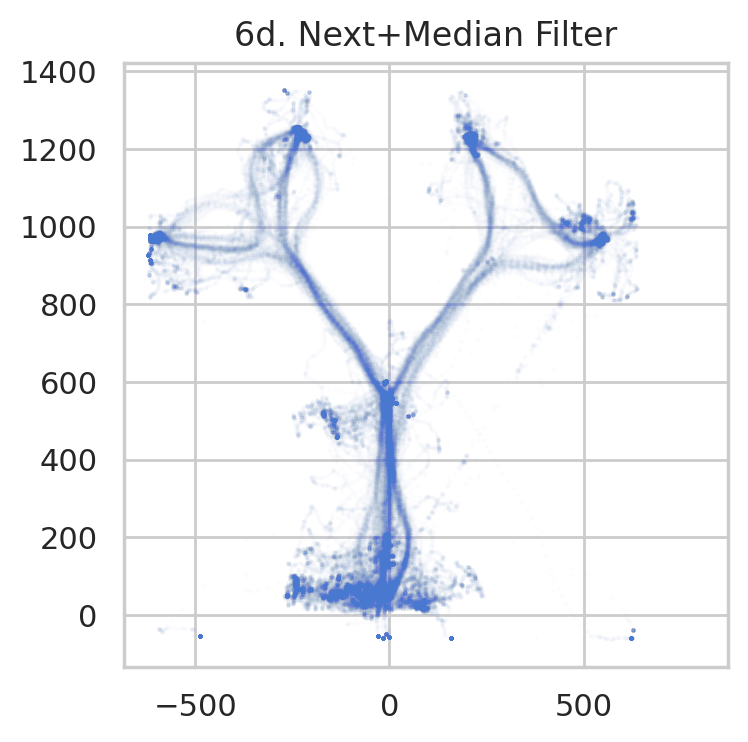

In [236]:
 # 8. median filter the data to deal with nan
x6d = filter_funcs.median_window_filtfilt(x6b, 5)
y6d = filter_funcs.median_window_filtfilt(y6b, 5)

f,ax=plt.subplots(dpi=200)
ax.scatter(x6d, y6d, s=0.5, marker = '.', alpha=0.02)
ax.set_title("6d. Next+Median Filter")
ax.axis("square")

In [231]:
%%time
#kalman
measurements = np.array((x5,y5)).T
measurements[nan_ids,:] = np.ma.masked
m_cov = np.cov(measurements.T)

transition_matrix = [[1, 1, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 1, 1],
                     [0, 0, 0, 1]]

observation_matrix = [[1, 0, 0, 0],
                      [0, 0, 1, 0]]

kf = KalmanFilter(transition_matrices = transition_matrix,
                  observation_matrices = observation_matrix,
                  #initial_state_mean = [x5[0],0,y5[0],0],
                  observation_covariance = m_cov,
                  em_vars=['transition_covariance', 'initial_state_covariance']
                 )

kf = kf.em(measurements, n_iter=5)
(smoothed_state_means, smoothed_state_covariances) = kf.smooth(measurements)


CPU times: user 4min 49s, sys: 159 ms, total: 4min 50s
Wall time: 4min 48s


(-690.4916771644185,
 827.0249358336456,
 -124.44619430718058,
 1393.0704186908836)

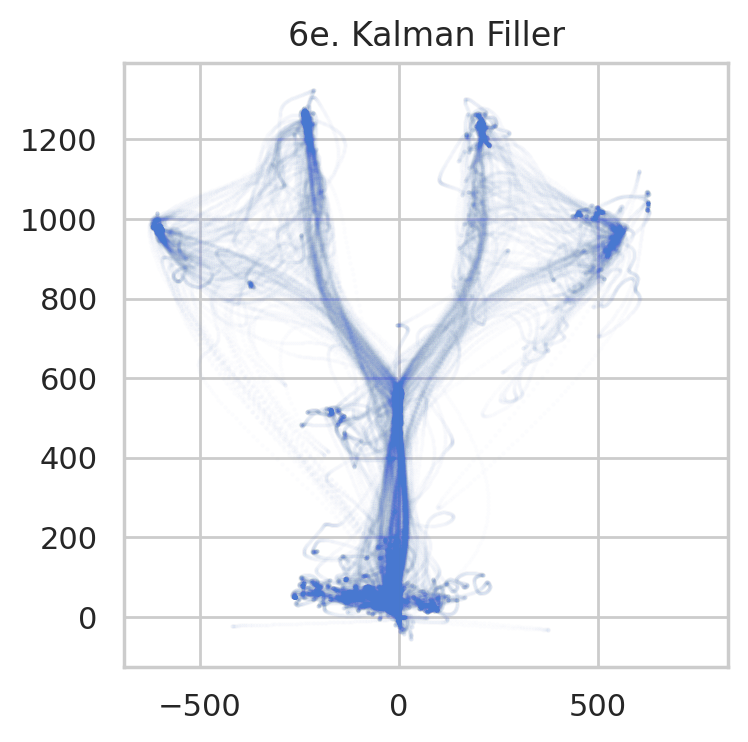

In [234]:
x6e = smoothed_state_means[:,0]
y6e = smoothed_state_means[:,2]


f,ax=plt.subplots(dpi=200)
ax.scatter(x6e, y6e, s=0.5, marker = '.', alpha=0.02)
ax.set_title("6e. Kalman Filler")
ax.axis("square")


(-683.3149662694532,
 874.0352705376986,
 -134.41874458619455,
 1422.9314922209571)

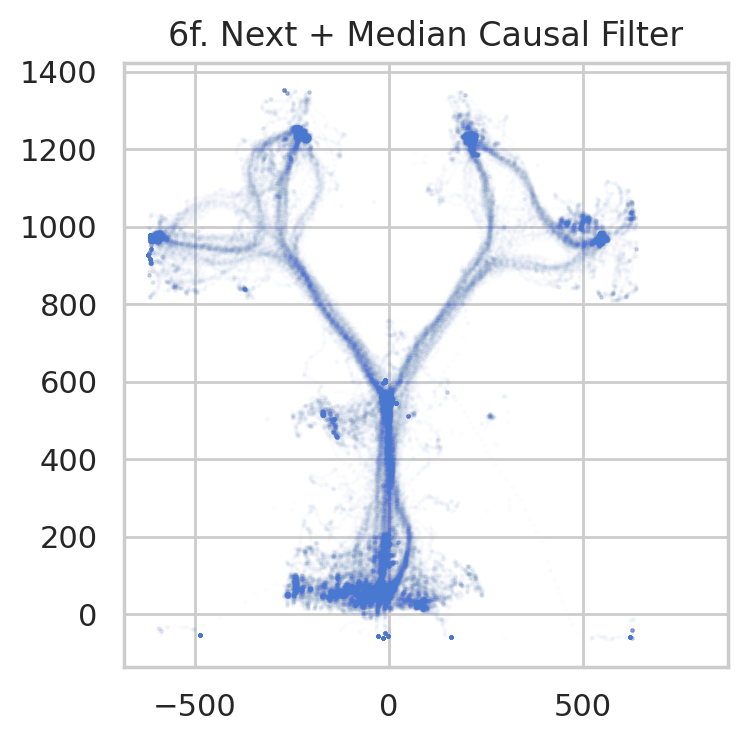

In [243]:
filter_funcs = reload(filter_funcs)

x6f = filter_funcs.median_window_filter_causal(x6b, 3)
y6f = filter_funcs.median_window_filter_causal(y6b, 3)

f,ax=plt.subplots(dpi=200)
ax.scatter(x6f, y6f, s=0.5, marker = '.', alpha=0.02)
ax.set_title("6f. Next + Median Causal Filter")
ax.axis("square")

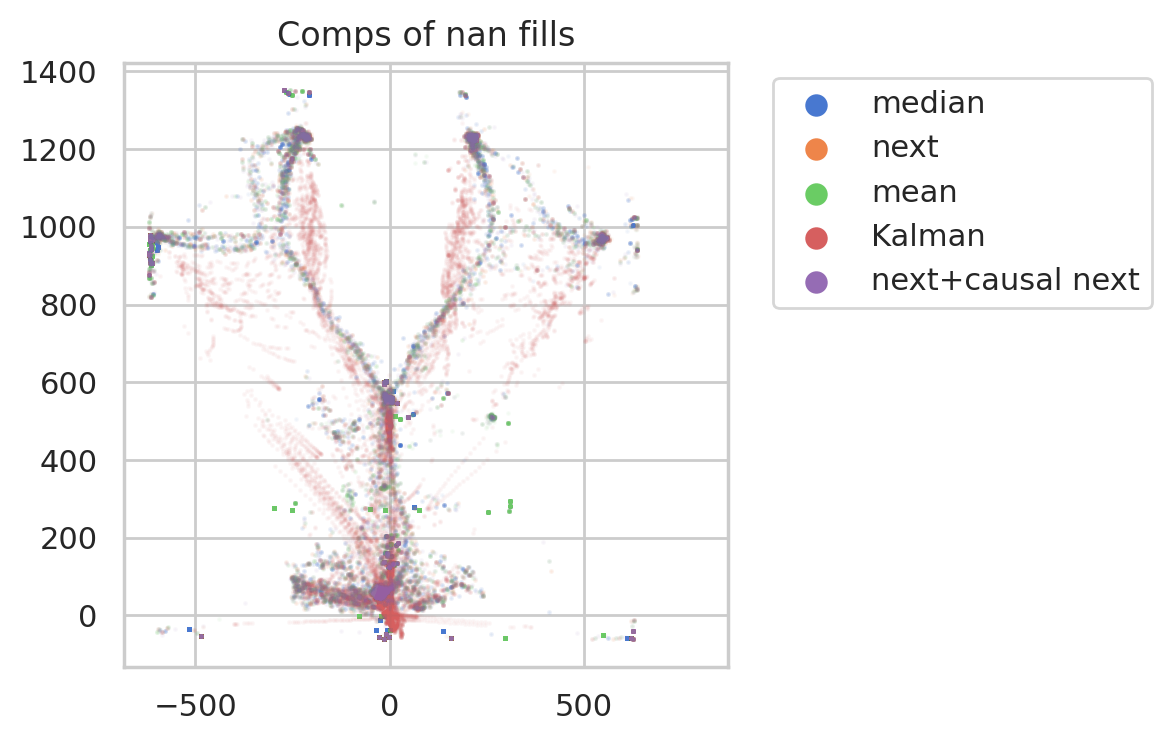

In [290]:
nan_ids = np.where(np.logical_or(np.isnan(x5), np.isnan(y5)))[0]

f,ax=plt.subplots(dpi=200)
ax.scatter(x6a[nan_ids], y6a[nan_ids], s=0.5, marker = 'o', alpha=0.05, label='median')
ax.scatter(x6b[nan_ids], y6b[nan_ids], s=0.5, marker = 'o', alpha=0.05, label='next')
ax.scatter(x6c[nan_ids], y6c[nan_ids], s=0.5, marker = 'o', alpha=0.05, label='mean')
ax.scatter(x6e[nan_ids], y6e[nan_ids], s=0.5, marker = 'o', alpha=0.05, label='Kalman')
ax.scatter(x6f[nan_ids], y6f[nan_ids], s=0.5, marker = 'o', alpha=0.05, label='next+causal next')


ax.set_title("Comps of nan fills")
ax.axis("square")
l = ax.legend(markerscale=10, bbox_to_anchor=(1.05, 1))
for lh in l.legendHandles: 
    lh.set_alpha(1)

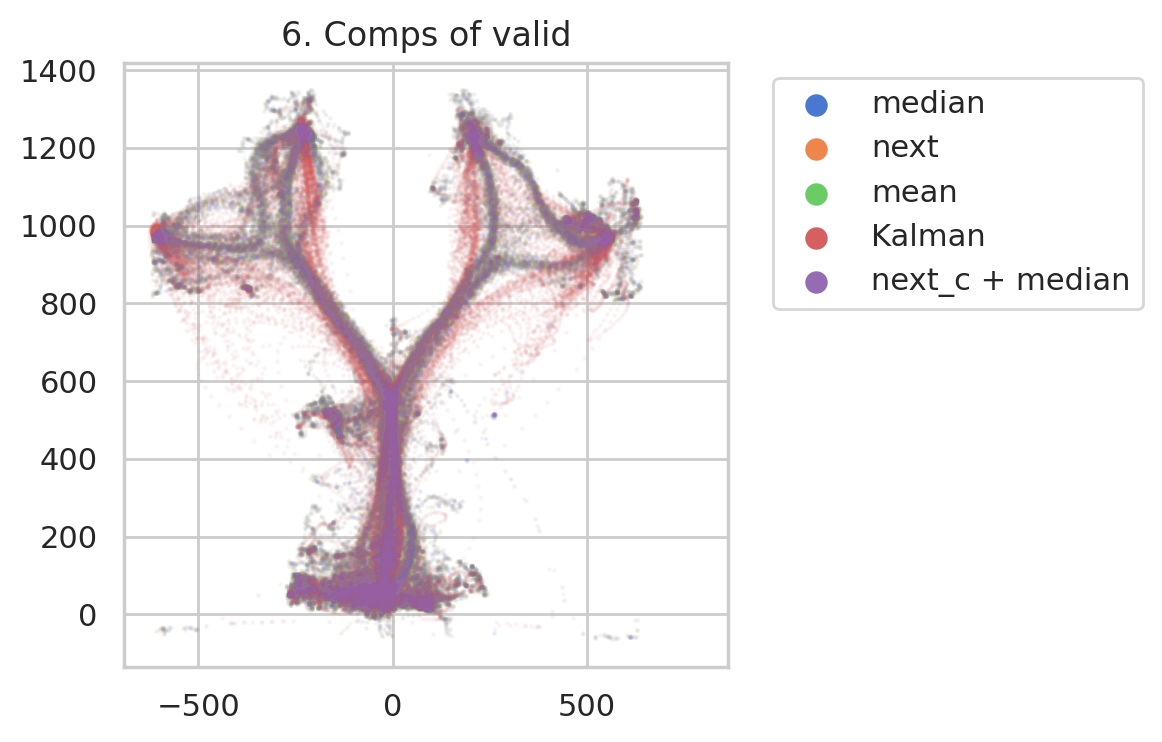

In [251]:
non_nan_ids = np.where(~np.logical_or(np.isnan(x5), np.isnan(y5)))[0]

non_nan_ids = non_nan_ids[::3]
f,ax=plt.subplots(dpi=200)
ax.scatter(x6a[non_nan_ids], y6a[non_nan_ids], s=0.5, marker = 'o', alpha=0.05, label='median')
ax.scatter(x6b[non_nan_ids], y6b[non_nan_ids], s=0.5, marker = 'o', alpha=0.05, label='next')
ax.scatter(x6c[non_nan_ids], y6c[non_nan_ids], s=0.5, marker = 'o', alpha=0.05, label='mean')
ax.scatter(x6e[non_nan_ids], y6e[non_nan_ids], s=0.5, marker = 'o', alpha=0.05, label='Kalman')
ax.scatter(x6f[non_nan_ids], y6f[non_nan_ids], s=0.5, marker = 'o', alpha=0.05, label='next_c + median')


ax.set_title("6. Comps of valid")
ax.axis("square")
l = ax.legend(markerscale=10, bbox_to_anchor=(1.05, 1))
for lh in l.legendHandles: 
    lh.set_alpha(1)

In [255]:
len(nan_ids)/len(x6)

0.08357466016715963

(-683.2756151368359, 871.513965606836, -131.97448198014678, 1422.8150987635252)

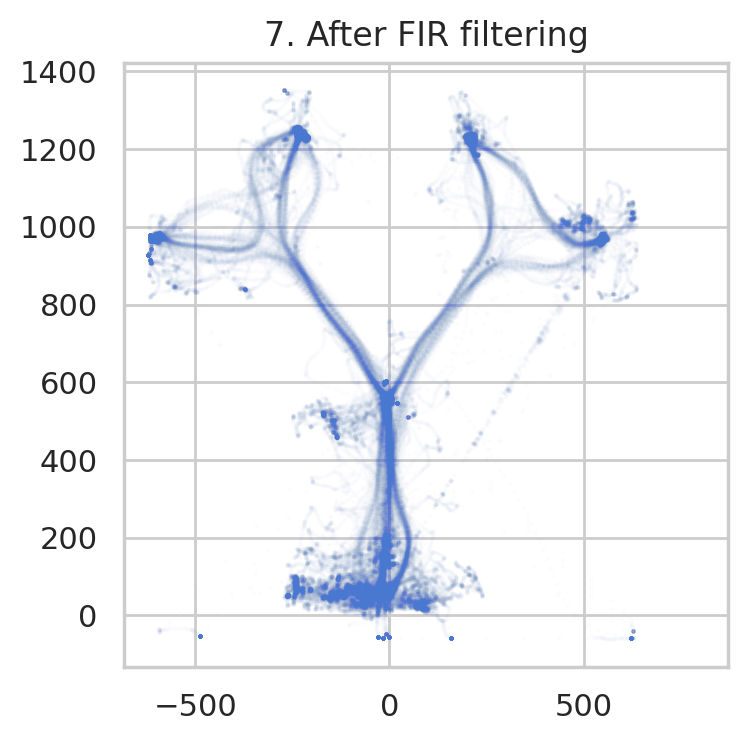

In [261]:
# 10. final filter / smoothing
x7 = filter_funcs.filtfilt(p.filter_coef_, 1, x6f)
y7 = filter_funcs.filtfilt(p.filter_coef_, 1, y6f)

f,ax=plt.subplots(dpi=200)
ax.scatter(x9, y9, s=0.5, marker = '.', alpha=0.02)
ax.set_title("7. After FIR filtering")
ax.axis("square")

## Different approach for the last part of processing
Use smoothing filter on non nan values first, then use median filter / fill nan values. 



In [309]:
x6g =x5.copy()
y6g =y5.copy()

x6g[~nan_ids] =filter_funcs.filtfilt(p.filter_coef_, 1, x6g[~nan_ids]) 
y6g[~nan_ids] = filter_funcs.filtfilt(p.filter_coef_, 1, y6g[~nan_ids])

In [310]:
x7b = filter_funcs.fill_nan_vals(x6g)
y7b = filter_funcs.fill_nan_vals(y6g)

In [311]:
x7c = filter_funcs.fill_nan_vals(x6g, 'both')
y7c = filter_funcs.fill_nan_vals(y6g, 'both')

In [312]:
x8b = filter_funcs.median_window_filter_causal(x7b, 5)
y8b = filter_funcs.median_window_filter_causal(y7b, 5)

In [313]:
x8c = filter_funcs.median_window_filter_causal(x7c, 5)
y8c = filter_funcs.median_window_filter_causal(y7c, 5)

In [314]:
x8d = filter_funcs.filtfilt(p.filter_coef_, 1, x7b)
y8d = filter_funcs.filtfilt(p.filter_coef_, 1, y7b)

(-683.4746196165797,
 872.5389720885726,
 -133.14285607974074,
 1422.8707356254115)

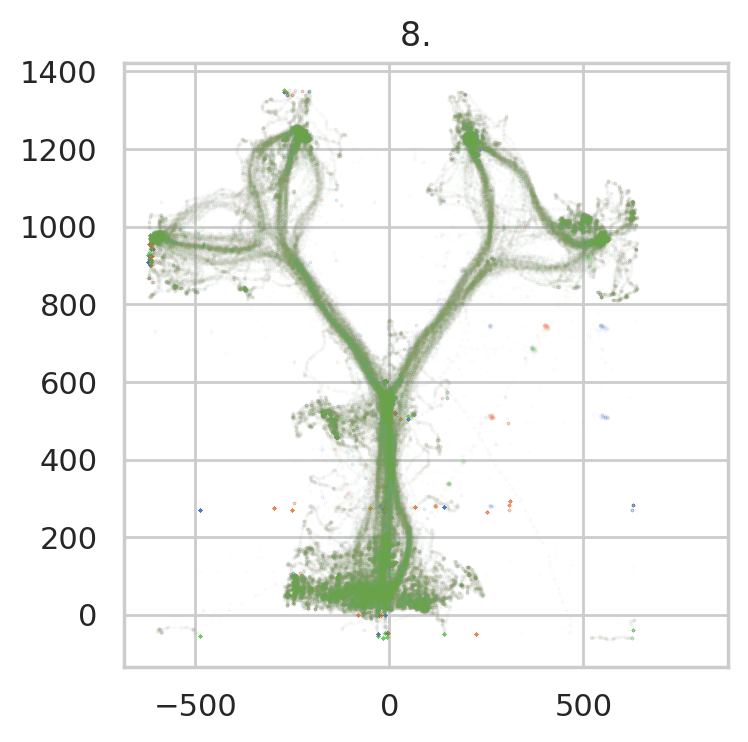

In [316]:

f,ax=plt.subplots(dpi=200)
#ax.scatter(x6b, y6b, s=1, marker = '.', alpha=0.05)
ax.scatter(x8b, y8c, s=0.1, marker = '.', alpha=0.05, label='sm_f + last nan fill + median_f_c')
ax.scatter(x8c, y8c, s=0.1, marker = '.', alpha=0.05, label='sm_f + both nan fill + median_f_c')
ax.scatter(x8d, y8d, s=0.1, marker = '.', alpha=0.05,  label='sm_f + last nan fill + sm_f')

#ax.scatter(x7bi, y7bi, s=0.1, marker = '.', alpha=0.05)

#ax.scatter(x7c, y7c, s=0.1, marker = '.', alpha=0.05)

ax.set_title("8.  ")
ax.axis("square")

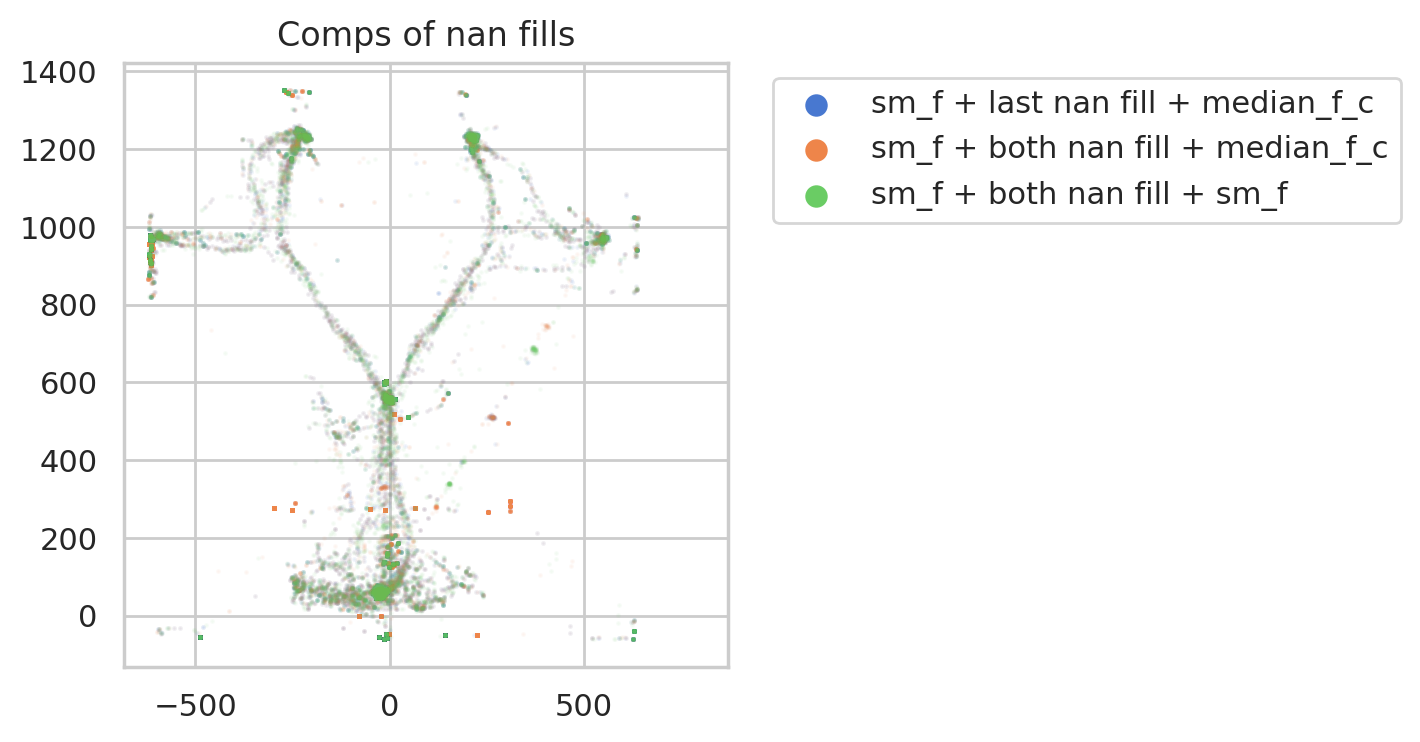

In [320]:
nan_ids = np.where(np.logical_or(np.isnan(x5), np.isnan(y5)))[0]

f,ax=plt.subplots(dpi=200)
#ax.scatter(x6f[nan_ids], y6f[nan_ids], s=0.5, marker = 'o', alpha=0.1, label='last nan fill +causal median')

ax.scatter(x8b[nan_ids], y8b[nan_ids], s=0.5, marker = 'o', alpha=0.075, label='sm_f + last nan fill + median_f_c')
ax.scatter(x8c[nan_ids], y8c[nan_ids], s=0.5, marker = 'o', alpha=0.05, label='sm_f + both nan fill + median_f_c')
ax.scatter(x8d[nan_ids], y8d[nan_ids], s=0.5, marker = 'o', alpha=0.05, label='sm_f + both nan fill + sm_f')

ax.set_title("Comps of nan fills")
ax.axis("square")
l = ax.legend(markerscale=10, bbox_to_anchor=(1.05, 1))
for lh in l.legendHandles: 
    lh.set_alpha(1)

## Conclusions from the above. 
After qualitative observations and reasonable compromises in terms of time-series causality, this is the final approach.

1. masks xy pixel data for out track bound spaces. values set to np.nan
2. centers the xy pixel data
3. rotates xy to the experimenters perspective
4. rescales data from pixels to mm
5. masks velocity to create a masks for a velocity threshold
6. smooth the data for excluding nan vals (non-causal)
7. fill in nan values with last value (causal)
8. apply median filters (causal)
9. re-sample

In [326]:
# resampled time
t_rs = session_info.get_time()

# get raw behavior
t_vt, x_vt, y_vt, ha_vt = session_info.get_raw_track_data()
x = x_vt
y = y_vt
ha = ha_vt
t = t_vt

In [329]:
# make deep copies
x1 = x.copy()
y1 = y.copy()
ha1 = ha.copy()

# 1. mask pixels that are out of bounds
mask_x = np.logical_or(x1 < p.x_pix_lims[0], x1 > p.x_pix_lims[1])
mask_y = np.logical_or(y1 < p.y_pix_lims[0], y1 > p.y_pix_lims[1])
mask = np.logical_or(mask_x, mask_y)

x1[mask] = np.nan
y1[mask] = np.nan
ha1[mask] = np.nan

# 2. centering / pixel translation
x2 = x1 + p.x_pix_bias
y2 = y1 + p.y_pix_bias

# 3. rotate to experimenter's pov
x3, y3 = spatial_funcs.rotate_xy(x2, y2, p.xy_pix_rot_rad)

# 4. convert to mm / re-scales; bias term re-frames the image
x4 = x3 * p.x_pix_mm + p.x_mm_bias
y4 = y3 * p.y_pix_mm + p.y_mm_bias

# 5. filter by valid speed values
with np.errstate(invalid='ignore'):  # avoids warnings about comparing nan values
    # 5a. compute velocity to create speed threshold
    dx = np.append(0, np.diff(x4))
    dy = np.append(0, np.diff(y4))
    dr = np.sqrt(dx ** 2 + dy ** 2)
    mask_r = np.abs(dr) > p.max_speed_thr

    # 5b. mask creating out of bound zones in mm space
    mask_x = np.logical_or(x4 < p.x_mm_lims[0], x4 > p.x_mm_lims[1])
    mask_y = np.logical_or(y4 < p.y_mm_lims[0], y4 > p.y_mm_lims[1])
    mask = np.logical_or(mask_x, mask_y)
    mask = np.logical_or(mask, mask_r)

# 5c. apply masks
x5 = x4.copy()
y5 = y4.copy()
ha5 = ha1.copy()

x5[mask] = np.nan
y5[mask] = np.nan
ha5[mask] = np.nan

# get nan idx for future use.
nan_idx = np.where(np.logical_or(np.isnan(x5), np.isnan(y5)))[0]

# 6. smooth non nan-vals
x6 = x5.copy()
y6 = y5.copy()
ha6 = ha5.copy()

x6[~nan_idx] = filter_funcs.filtfilt(p.filter_coef_, 1, x6[~nan_idx])
y6[~nan_idx] = filter_funcs.filtfilt(p.filter_coef_, 1, y6[~nan_idx])
ha6[~nan_idx] = filter_funcs.angle_filtfilt(ha6[~nan_idx], p.filter_coef_angle_)

# 7. fill in nan vals
x7 = filter_funcs.fill_nan_vals(x6)
y7 = filter_funcs.fill_nan_vals(y6)
ha7 = filter_funcs.fill_nan_vals(ha6)

# 8. median filter
x8 = filter_funcs.median_window_filter_causal(x7, p.temporal_window_size)
y8 = filter_funcs.median_window_filter_causal(y7, p.temporal_window_size)
ha8 = filter_funcs.median_window_filter_causal(ha7, p.temporal_angle_window_size)

# 9. resample
x9 = filter_funcs.resample_signal(t, t_rs, x8)
y9 = filter_funcs.resample_signal(t, t_rs, y8)
ha9 = filter_funcs.resample_signal(t, t_rs, ha8)


In [332]:
xs = np.zeros(9,dtype=object)
ys = np.zeros(9,dtype=object)

for ii in range(9):
    xs[ii] = eval(f"x{ii+1}")
    ys[ii] = eval(f"y{ii+1}")

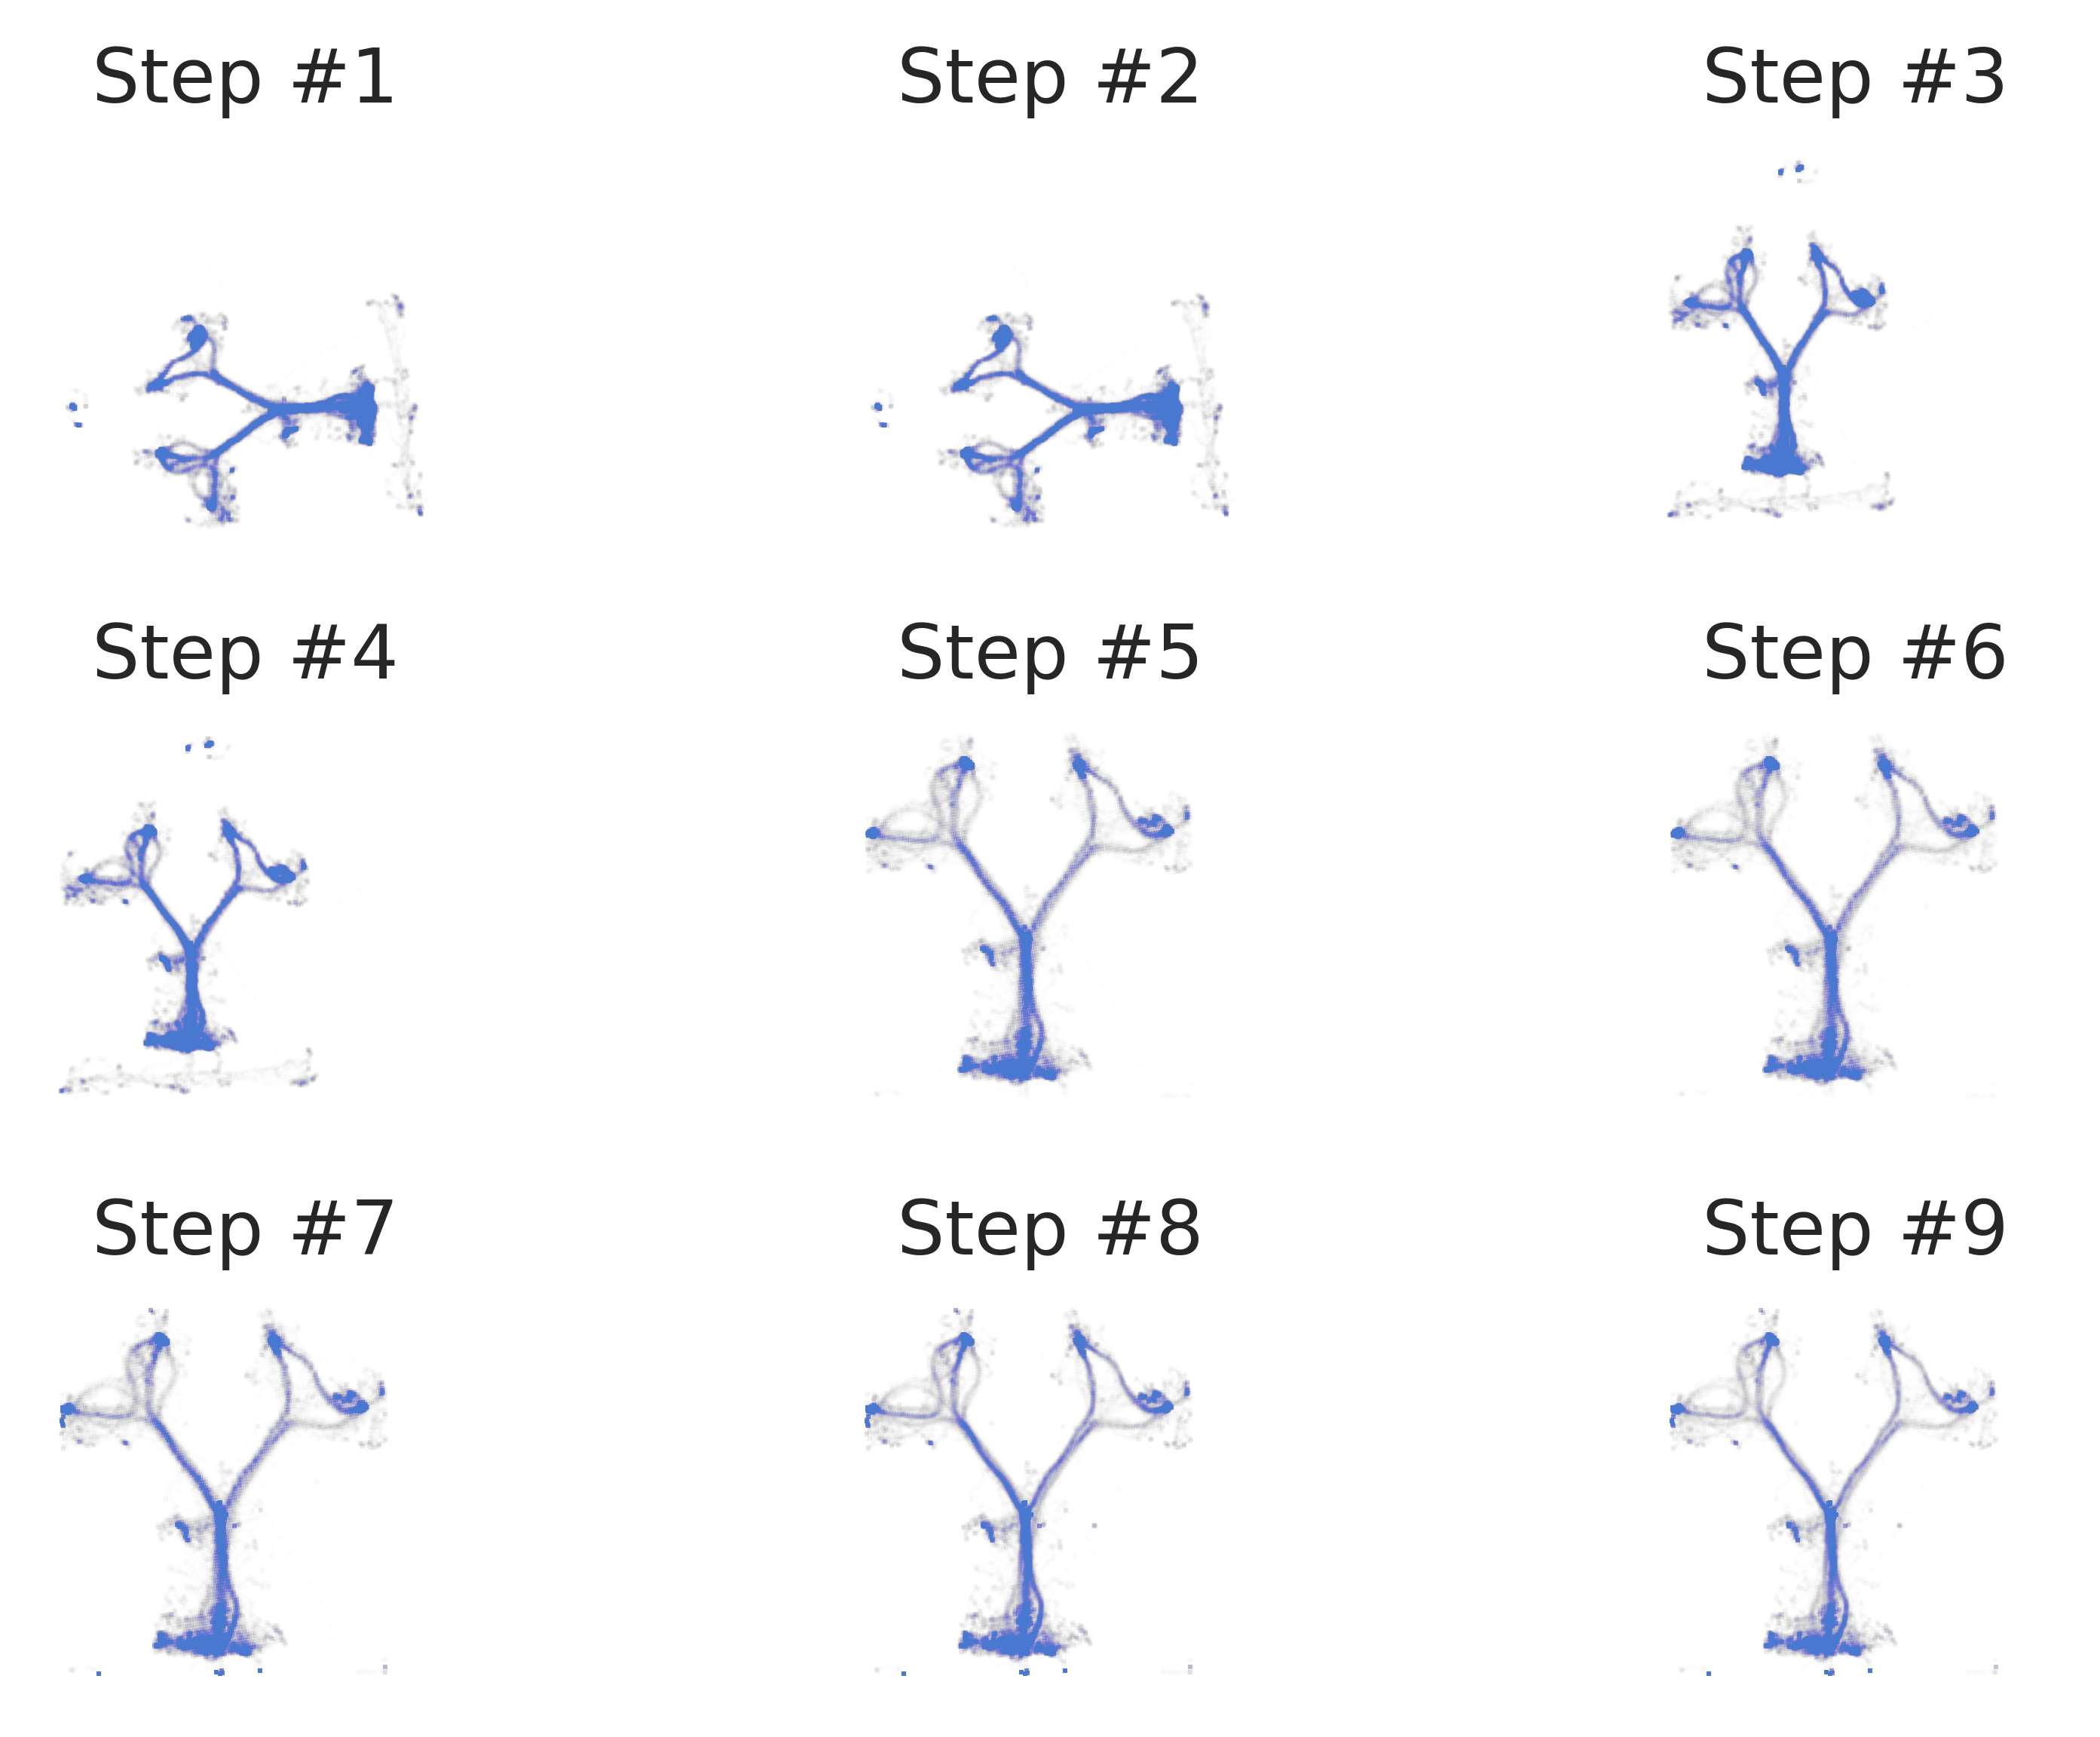

In [344]:

f,ax=plt.subplots(3,3, dpi=600)
ax = ax.flatten()
#ax.scatter(x6f[nan_ids], y6f[nan_ids], s=0.5, marker = 'o', alpha=0.1, label='last nan fill +causal median')
for ii in range(9):
    ax[ii].scatter(xs[ii], ys[ii], s=0.5, marker = ',', linewidths=0, alpha=0.005)
    ax[ii].set_title(f"Step #{ii+1}")
    ax[ii].axis("square")
    ax[ii].axis("off")
plt.tight_layout()

## check the API

In [509]:
tmf = reload(tmf)
xs2,ys2,has2,nan_idx = tmf.pre_process_track_data(x, y, ha, t, t_rs, p, return_all=True)

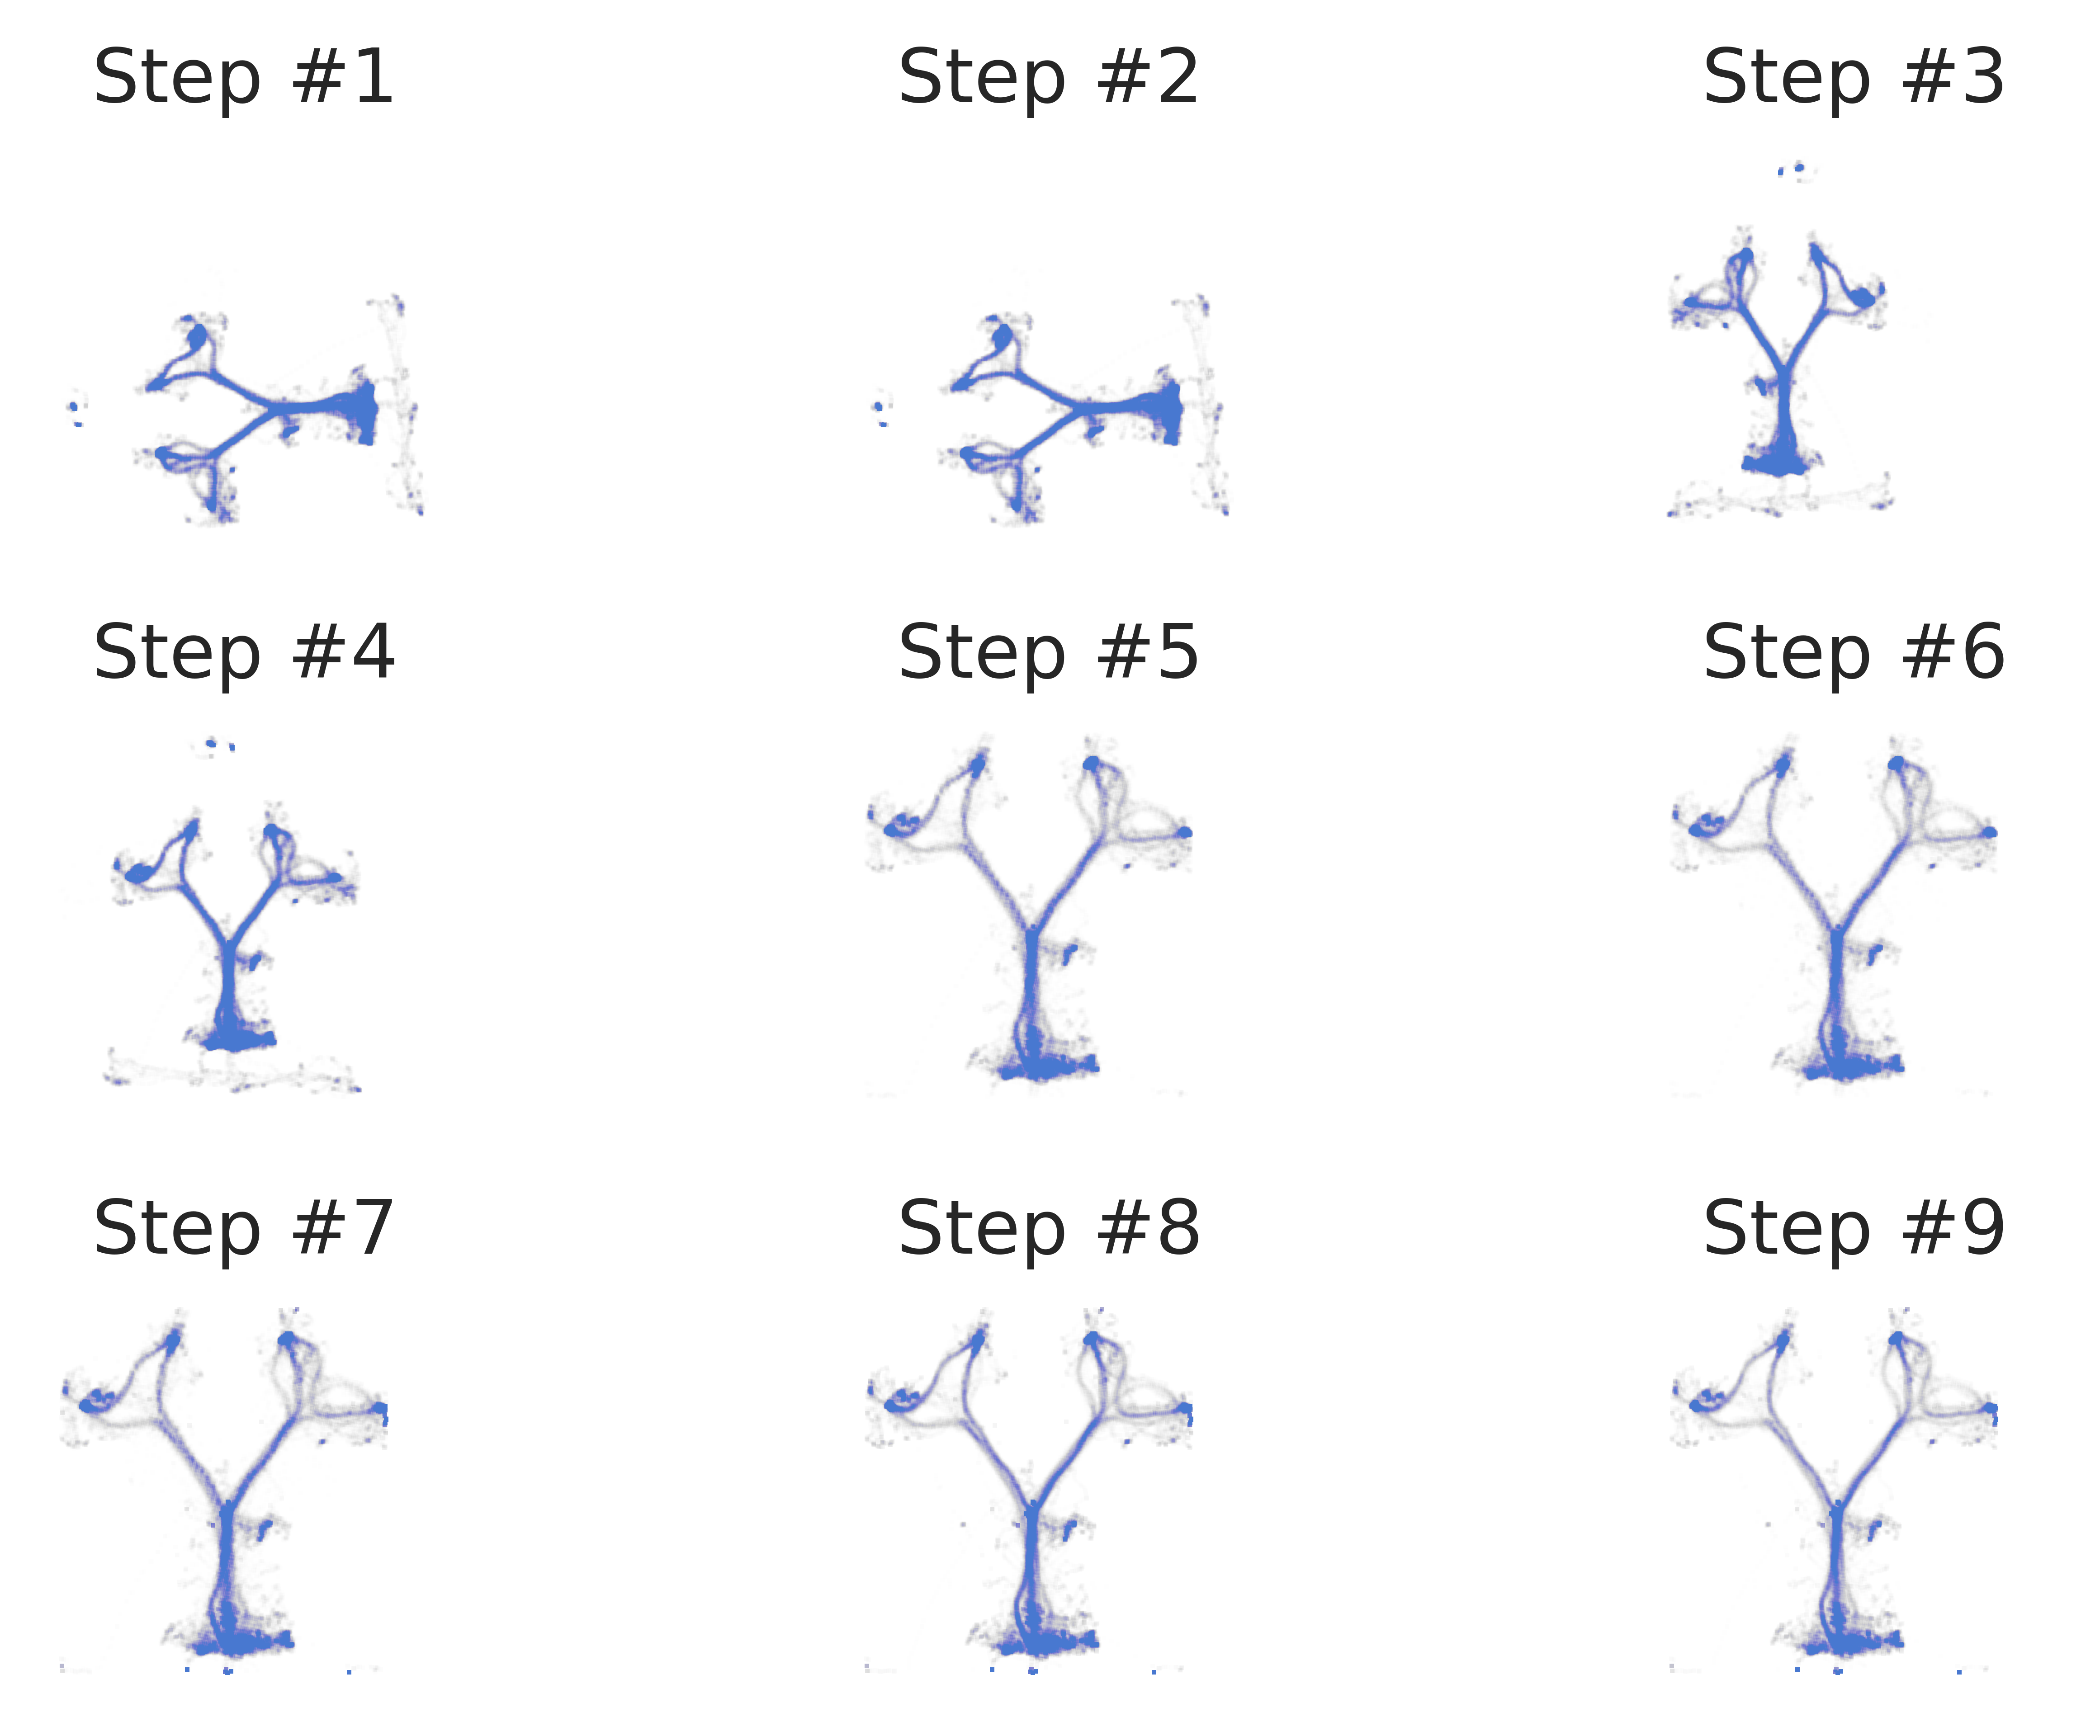

In [510]:
f,ax=plt.subplots(3,3, dpi=1000)
ax = ax.flatten()
#ax.scatter(x6f[nan_ids], y6f[nan_ids], s=0.5, marker = 'o', alpha=0.1, label='last nan fill +causal median')
for ii in range(9):
    ax[ii].scatter(xs2[ii], ys2[ii], s=0.5, marker = ',', linewidths=0, alpha=0.005)
    ax[ii].set_title(f"Step #{ii+1}")
    ax[ii].axis("square")
    ax[ii].axis("off")
plt.tight_layout()

In [514]:
np.max(ys2[8]) - np.min(ys2[8]), np.max(xs2[8]) - np.min(xs2[8]), 


(1409.4127015022984, 1259.3314601282113)

In [387]:
gd_fig_path = Path("/home/alexgonzalez/google-drive/TreeMazeProject/Figures/")

fig_name = "behav_pre_process.jpeg"
f.savefig(gd_fig_path/fig_name, bbox_inches='tight')


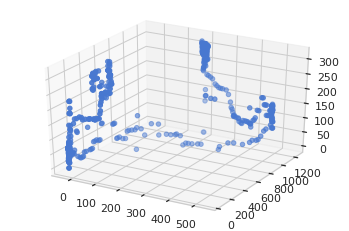

In [382]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

step = 8
#np.random.seed(9)
win_len = 500
win_start = np.random.randint(len(x)-win_len)
window = np.arange( win_start, win_start+win_len)

ax.scatter(xs2[step][window],ys2[step][window],has2[step][window])

In [497]:
tmf = reload(tmf)
xs2,ys2,has2,nan_idx = tmf.pre_process_track_data(x, y, ha, t, t_rs, p)

In [498]:
 df = pd.DataFrame(columns=['t', 'x', 'y', 'ha'])
df['x'] = xs2
df['y'] = ys2
df['ha'] = has2
df['t'] = t_rs


In [503]:
df.to_csv('temp.csv')

In [505]:
df2 = pd.read_csv('temp.csv', index_col=0)

In [506]:
df2.head()

t           x           y     ha
0  489.949 -181.737253  845.534662  128.0
1  489.969 -169.425800  824.788215  104.0
2  489.989 -164.865393  824.547630  104.0
3  490.009 -156.566440  812.051645   82.0
4  490.029 -129.115424  778.448335   97.0

In [508]:
print(f"dfsfd  {xs2[0]:0.2f}")

dfsfd  -181.74


## get events

In [388]:
import Pre_Processing.pre_process_functions as pp_funcs

In [443]:
events_path = Path(session_info.paths['Raw'], 'Events.nev')
ev = pp_funcs.get_events(events_path)

In [392]:
ev.keys()

dict_keys(['DE1', 'DE2', 'DE3', 'DE4', 'DE5', 'DE6', 'L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'RD', 'CL', 'CR', 'Start', 'Stop'])

In [398]:
((np.arange(10)+0.2)//2).astype(int)

array([0, 0, 1, 1, 2, 2, 3, 3, 4, 4])

In [435]:
n_totol_events = 0

all_events_list = []
all_events_times = np.zeros(0)
for k_event, k_event_times in ev.items():
    n_k_events = len(k_event_times)
    
    all_events_list += [k_event]*n_k_events
    all_events_times = np.concatenate((all_events_times, k_event_times))
    
    n_totol_events += n_k_events

sorted_events_idx = np.argsort(all_events_times)

df = pd.DataFrame(index=range(n_totol_events), columns=['event', 't0', 'tE', 'dur', 'trial_num'] )
df['event'] = np.array(all_events_list)[sorted_events_idx]
df['t0'] = (all_events_times[sorted_events_idx] // 0.02).astype(int)


In [460]:
ii = 7
ev_ii = df.loc[ii]['event']
t0 = df.loc[ii]['t0']


In [493]:
max_d = 1
scope = df.loc[(df.t0>t0) & (df.t0<=t0+max_d) & (df.event.isin(['RD']))]['t0'].values

In [494]:
scope[0]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [456]:

end_ev = 'DE1'
t0 = 2000
t0_next = 2050
ix = np.logical_and(ev[end_ev] >= t0, ev[end_ev] < t0_next)
ev[end_ev][ix][0]

2031.7548929999998

In [496]:
tmf = reload(tmf)
b = tmf.BehaviorData(session_info)

AttributeError: 'SubjectSessionInfo' object has no attribute 'get_events'

## check parameters with other subjects

In [111]:

subject_info = si.SubjectInfo(subject)

In [117]:
cnt = 0
for session in subject_info.sessions:
    if 'T3' in session:
        cnt+=1
cnt

36

In [116]:
subject_info.results_path

ls: cannot access 'subject_info.results_path': No such file or directory
